# Ingeniería de Datos

In [1]:
import cv2
import mediapipe as mp
import numpy as np
import csv
import os
from matplotlib import pyplot as plt
import pandas as pd

In [22]:
EXPORT_PATH = 'push-up-reload.csv'

In [23]:
df = pd.read_csv(EXPORT_PATH)
df['class'].value_counts()

1    4296
0    2730
Name: class, dtype: int64

In [31]:
X = df.drop('class', axis=1) # features
y = df['class'] # target

## Más sobre evaluación de modelos y selección de features

entender como el umbral para asignar las clases nos permite ajustar el error tipo 1 y tipo 2, resolver el problema de clases desbalanceadas, y conseguir una métrica de performance que nos diga qué tan bueno es el clasificador independientemente de valores específicos para los errores tipo 1 y  2. 


In [25]:
import matplotlib.pylab as plt # Para gráficos
import numpy as np # Para manejo de arrays, operaciones matemáticas, etc.
from sklearn.linear_model import LogisticRegression # El método de regresión logística que vamos a usar
import pandas as pd # Para manejo de base de datos


In [32]:
scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza l datos al intervalo [0,1]
scaler.fit(X) # encuentro los parametros para el escaleo
X = scaler.transform(X) # aplico la transformacion

regLog = LogisticRegression(max_iter=20000) # Inicializamos nuevamente el modelo
regLog.fit(X, y) # Ajustamos el modelo con los parámetros
probas = regLog.predict_proba(X)  # este es el metodo para obtener las predicciones de probabilidades en base a la matriz features
print(probas)

[[0.05427823 0.94572177]
 [0.05504071 0.94495929]
 [0.09898587 0.90101413]
 ...
 [0.00726442 0.99273558]
 [0.00896007 0.99103993]
 [0.01337917 0.98662083]]


La primera columna es $P(y=0|x,\beta)$. 

La segunda es $P(y=1|x,\beta)$. 

Entonces, el clasificador por defecto predice etiqueta $1$ si $P(y=1|x,\beta) > 0.5$, o sea, cuando la segunda columna es mayor que 0.5 y la etiqueta $0$ en caso contrario.
Pero podemos introducir un umbral arbitrario $T$ para determinar la etiqueta $1$ si $P(y=1|x,\beta) > T$. 
Veamos como queda la matriz de confusión para distintas elecciones de T.
Ademas, vamos a calcular dos medidas de performance útiles para más adelante:

*   Tasa de verdaderos positivos (sensibilidad)$ = \frac{TP}{TP+FN}$
*   Tasa de falsos positivos $ = \frac{FP}{FP+TN}$

donde TP = verdaderos positivos, FN = falsos negativos, FP = falsos positivos y TN = verdaderos negativos.

In [38]:

from sklearn.metrics import confusion_matrix

def TPR_FPR(cm): # computa la tasa de verdaderos y falsos positivos a partir de la matriz de confusion
  TPR = cm[1,1]/(cm[1,1]+cm[0,1])
  FPR = cm[1,0]/(cm[1,0]+cm[0,0])
  return [TPR,FPR] # devuelve una lista donde el primer elemento es la tasa de verdaderos positivos y el segundo la tasa de falsos negativos

T = 0.5 # definimos el umbral
ypred = np.zeros(probas.shape[0]) # armamos un vector que tiene todos ceros y tiene la longitud del vector de etiquetas
ypred[probas[:,1]>T] = 1 # donde la probabilidad es mayor que T, ponemos 1
cm = confusion_matrix(ypred, y) # metemos en la matriz de confusion
metricas = TPR_FPR(cm)

print('Matriz de confusion del modelo es:')
print(cm)
print('Tasa de verdaderos positivos: {}'.format(round(metricas[0],4)))  
print('Tasa de falsos positivos: {}'.format(round(metricas[1],4)))  

Matriz de confusion del modelo es:
[[2413  322]
 [ 317 3974]]
Tasa de verdaderos positivos: 0.925
Tasa de falsos positivos: 0.1161


Text(0, 0.5, 'Tasa de verdaderos positivos')

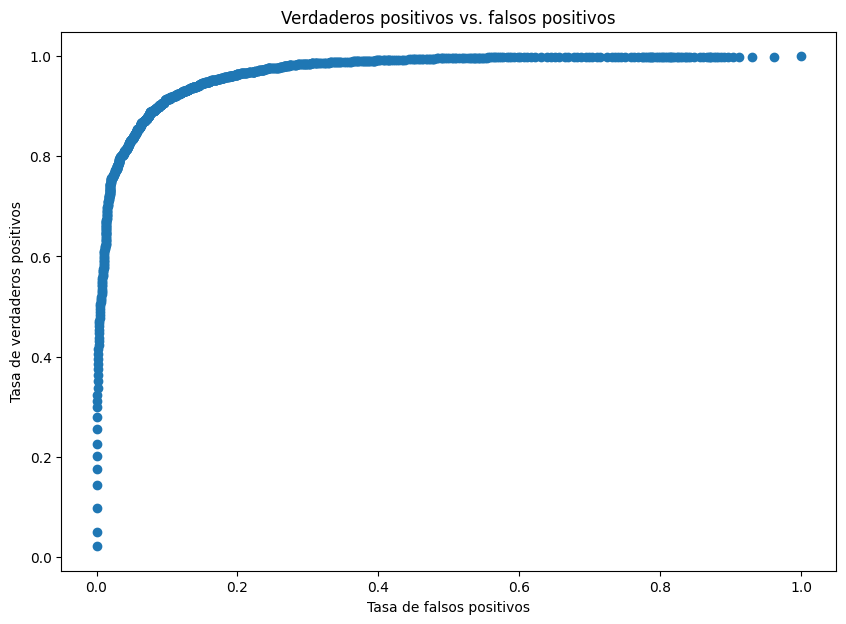

In [40]:
Ts = np.arange(0,1,0.001) # T va desde 0 a 1 en pasos de 0.001
TPRs = []  # lista donde van a ir a parar mis tasas de verdaderos positivos
FPRs = []  # lista donde van a ir a parar mis tasas de falsos positivos
for T in Ts: # recorre los umbrales en la lista Ts
  ypred = np.zeros(probas.shape[0]) # armamos un vector que tiene todos ceros y tiene la longitud del vector de etiquetas
  ypred[probas[:,1]>T] = 1 # donde la probabilidad es mayor que T, ponemos 1
  cm = confusion_matrix(ypred, y) # metemos en la matriz de confusion
  metricas = TPR_FPR(cm) # calculamos las metricas con la función definida más arriba
  TPRs.append(metricas[0]) # guardamos los resultados en las listas respectivas
  FPRs.append(metricas[1])

fig, ax = plt.subplots(figsize = (10,7))
ax.set_title('Verdaderos positivos vs. falsos positivos')
ax.scatter(FPRs,TPRs)
ax.set_xlabel('Tasa de falsos positivos') # Etiqueta del eje x
ax.set_ylabel('Tasa de verdaderos positivos') # Etiqueta del eje y

AUC: 0.9686


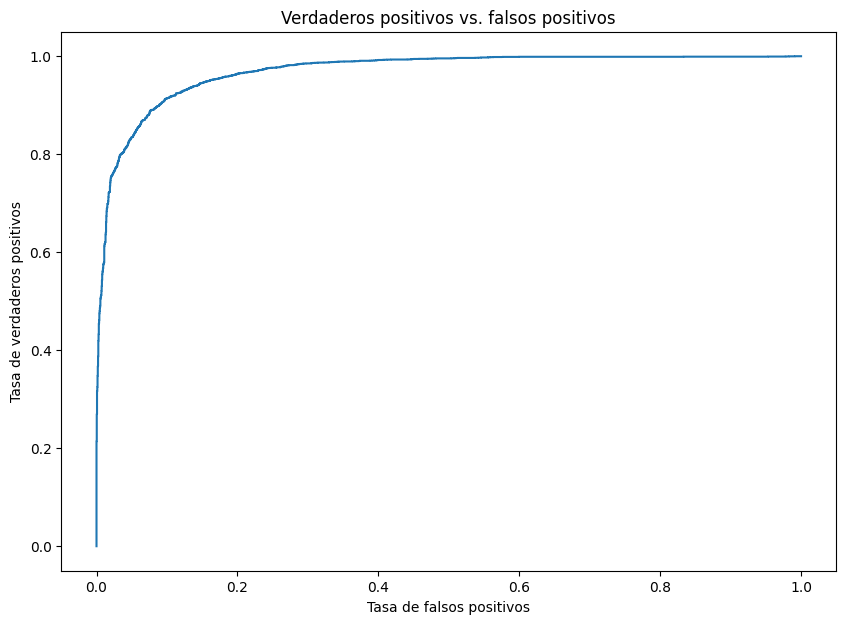

In [41]:
from sklearn.metrics import roc_curve # función curva ROC de scikit-learn
from sklearn.metrics import roc_auc_score # función AUC de scikit-learn

fpr, tpr, thresholds = roc_curve(y, probas[:,1]) # Función ROC: recibe las etiquetas verdaderas y las probas de que sean 1
                                                # Devuelve las tastas de falsos positivos y verdaderos positivos, además de los 
                                                # umbrales a los que están calculados
fig, ax = plt.subplots(figsize = (10,7))
ax.set_title('Verdaderos positivos vs. falsos positivos')
ax.plot(fpr,tpr) # Gráfico de TPR vs FPR
ax.set_xlabel('Tasa de falsos positivos') # Etiqueta del eje x
ax.set_ylabel('Tasa de verdaderos positivos') # Etiqueta del eje y

auc = roc_auc_score(y, probas[:,1]) # Cálculo del área debajo de la curva, recibe también las etiquetas verdaderas 
                                    # y la proba de que valgan 1.

print('AUC: {}'.format(round(auc,4))) # mostramos el AUC con 4 cifras significativas 

## Validación cruzada estratificada

Empecemos con un modelo que incorpora features elevadas al cuadrado, cubo., etc. para darle más flexibilidad al modelo. 

Calculemos el AUC y ploteemos la curva ROC para los datos de entrenamiento y de evaluación siguiendo un train-test split con 70-30.

In [13]:
X_1 = np.concatenate((X, X**2,X**3,X**4, X**5), axis=1)
X_1

array([[ 0.16646503,  0.34305251, -0.47380379, ...,  0.43355435,
         0.0410653 ,  0.00579726],
       [ 0.16219322,  0.33927152, -0.39474237, ...,  0.44718655,
         0.08611615,  0.00925744],
       [ 0.15591474,  0.35238674, -0.5405575 , ...,  0.41038562,
         0.25450627,  0.01249356],
       ...,
       [ 0.56817532,  0.68692696, -0.19972472, ...,  0.44927642,
         0.00784867,  0.29768629],
       [ 0.56765825,  0.68619537, -0.1707769 , ...,  0.44847766,
         0.0040505 ,  0.29970351],
       [ 0.56551397,  0.6849106 , -0.06012103, ...,  0.46517094,
         0.00080073,  0.26279368]])

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [14]:
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler 

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=0.3, random_state=1234)

# Supuestos: El dataset está normalizado desde el momento que son entregados por mediapipe.
# primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
scaler = MinMaxScaler() # escaleo por separado ambos sets. Por defecto, esto normaliza los datos al intervalo [0,1]
scaler.fit(X_train) # encuentro los parametros para el escaleo
X_train = scaler.transform(X_train) # aplico la transformacion

scaler = MinMaxScaler() # escaleo por separado ambos sets
scaler.fit(X_test) 
X_test = scaler.transform(X_test)
 

AUC entrenamiento: 0.9881
AUC evaluacion: 0.9882


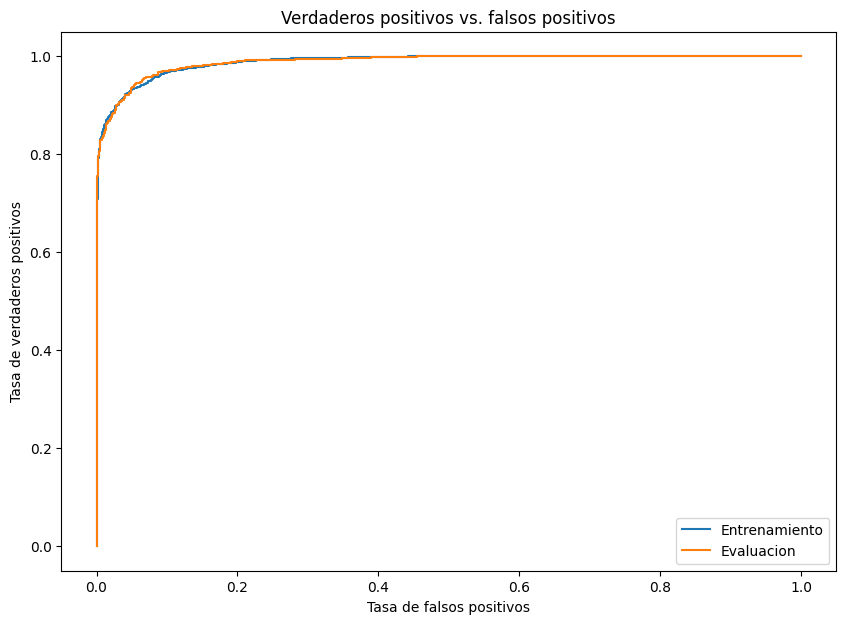

In [16]:
regLog_1 = LogisticRegression(max_iter=20000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
regLog_1.fit(X_train, y_train) # Ajustamos el modelo con los datos de entrenamiento

probas_train = regLog_1.predict_proba(X_train)  # probabilidades con datos de entrenamiento
probas_test = regLog_1.predict_proba(X_test)  # probabilidades con datos de evaluación

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, probas_train[:,1]) # para plotear curva ROC con datos de entrenamiento
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de evaluacion

auc_train = roc_auc_score(y_train, probas_train[:,1]) #  AUC con datos de entrenamiento
auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación

# para plotear ROC (codigo de un notebook anterior)

fig, ax = plt.subplots(figsize = (10,7))
ax.set_title('Verdaderos positivos vs. falsos positivos')
ax.plot(fpr_train,tpr_train, label = "Entrenamiento") # graficamos la curva ROC para el set de entrenamiento
ax.plot(fpr_test,tpr_test, label = "Evaluacion") # graficamos la curva ROC para el set de evaluacion

ax.set_xlabel('Tasa de falsos positivos') # Etiqueta del eje x
ax.set_ylabel('Tasa de verdaderos positivos') # Etiqueta del eje y

plt.legend()

print('AUC entrenamiento: {}'.format(round(auc_train,4)))  
print('AUC evaluacion: {}'.format(round(auc_test,4))) 

De esta forma, tenemos que todos los datos fueron usados una vez para evaluación y al menos una vez para entrenamiento. Además, tenemos una predicción para cada uno de los casos, y esta predicción no está afectada por overfitting (porque ese caso no fue usado en entrenamiento).

Veamos como funciona implementarlo en scikit-learn.

In [17]:
# Definamos la matriz X

X_1 = np.concatenate((X, X**2,X**3,X**4, X**5), axis=1) # agrego features elevados a potencias 

skf = StratifiedKFold(n_splits=5, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
skf.get_n_splits(X_1, y) # arma los folds a partir de los datos

auc_values = [] # aca es donde van a ir a parar los AUCs de cada fold
scores = np.array([])     # aca es donde van a ir a parar los scores computados para todos los casos
indices = np.array([])    # aca es donde van a ir a parar los indices correspondientes a las entradas de scores

for train_index, test_index in skf.split(X_1, y): # va generando los indices que corresponden a train y test en cada fold
    X_train, X_test = X_1[train_index], X_1[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
    y_train, y_test = y[train_index], y[test_index]     # idem con los targets

    regLog_1 = LogisticRegression(penalty = 'l2', max_iter=20000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
    regLog_1.fit(X_train, y_train) # Ajustamos el modelo con los datos de entrenamiento

    probas_test = regLog_1.predict_proba(X_test)  # probabilidades con datos de evaluación
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
    auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación

    auc_values.append(auc_test)
    scores = np.concatenate((scores,probas_test[:,1]),axis=0)
    indices = np.concatenate((indices,test_index),axis=0)

print("Estos son los valores AUC para cada fold:")
print(auc_values)
print("Estos es el promedio de todos los AUC:")
print(np.mean(auc_values))
print("Estos son las probabilidades para cada sample:")
print(scores)
print("Esta es la forma en que quedaron ordenados las entradas del vector anterior (indices):")
print(indices)

Estos son los valores AUC para cada fold:
[0.9829883294999575, 0.9901602084372748, 0.9897828209818897, 0.9859385860550005, 0.9881261540167244]
Estos es el promedio de todos los AUC:
0.9873992197981695
Estos son las probabilidades para cada sample:
[0.80061676 0.52785242 0.80070931 ... 0.99509956 0.99826925 0.99809914]
Esta es la forma en que quedaron ordenados las entradas del vector anterior (indices):
[2.000e+00 4.000e+00 7.000e+00 ... 7.006e+03 7.020e+03 7.021e+03]


In [45]:
def balanced_accuracy(cm): # funcion para calcular la "balanced accuracy"
  sensibilidad = cm[1,1]/(cm[1,1]+cm[0,1])
  especificidad = cm[0,0]/(cm[1,0]+cm[0,0])
  return [sensibilidad, especificidad, (sensibilidad + especificidad)/2]

In [46]:
X = df.drop('class', axis=1) # features
y = df['class'] # target

In [48]:
scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
scaler.fit(X) # encuentro los parametros para el escaleo
X = scaler.transform(X) # aplico la transformacion

regLog = LogisticRegression(class_weight='balanced', max_iter=20000) # Inicializamos nuevamente el modelo
regLog.fit(X, y) # Ajustamos el modelo con los parámetros
score = regLog.score(X,y) # Calculamos el score

ypred = regLog.predict(X) # con esto obtengo la predicción de las etiquetas en base a mis datos
cm = confusion_matrix(ypred, y) # primera entrada son las etiquetas predichas, segunda son las reales
metricas = balanced_accuracy(cm)

print('El score del modelo es de: {}'.format(round(score,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas[2],4))) 

El score del modelo es de: 0.9071
Matriz de confusion del modelo es:
[[2516  439]
 [ 214 3857]]
Sensibilidad del modelo es de: 0.8978
Especificidad del modelo es de: 0.9216
BA del modelo es de: 0.9097


## Optimización de hiperparámetros

Vimos que al sumar regularización, la performance del modelo de repente se ve incrementada en el test set. Posiblemente esto dependa del valor de la constante de penalización C que usamos para la regresión. **Esto es lo que llamamos un hiperparámetro del modelo.** Otro hiperparámetro posible es el grado de la potencia máxima en la que aparecen los features.

Entonces tiene sentido hacer la siguiente pregunta: ¿para qué elección de hiperparámetros **maximizo** la performance del clasificador en el dataset de evaluación (test)?

Vamos a proponer la siguiente forma de abordar este problema:

1.   Generamos una función que entrene y evalue el clasificador usando un train-test split, que incorpore como input los hiperparámetros
2.   Para cada elección del par de hiperparámetros, repetimos este procedimiento unas cuantas (>100) veces y nos quedamos con la performance promedio. Esto es necesario porque el train-test split es aleatorio.
3.   Repetimos para todas las combinaciones de nuestros hiperparámetros y encontramos aquella que maximiza la performance del clasificador.

In [50]:
X = df.drop('class', axis=1) # features
y = df['class'] # target

In [53]:
def classifier(X,y,n,c):  # X es la matriz de features, y los labels, n-1 la potencia máxima en la que aparecerán los features, C es la constante de regularización

  for i in np.arange(2,n):
     X = np.concatenate((X,X**i), axis=1)
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

  scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
  scaler.fit(X_train) # encuentro los parametros para el escaleo
  X_train = scaler.transform(X_train) # aplico la transformacion

  scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
  scaler.fit(X_test) # encuentro los parametros para el escaleo
  X_test = scaler.transform(X_test) # aplico la transformacion

  regLog = LogisticRegression(penalty = 'l2', class_weight='balanced', C=c, max_iter=20000) 
  regLog.fit(X_train, y_train) 
  
  ypred_train = regLog.predict(X_train) # con esto obtengo la predicción de las etiquetas en base a mis datos
  cm_train = confusion_matrix(ypred_train, y_train) # primera entrada son las etiquetas predichas, segunda son las reales
  metricas_train = balanced_accuracy(cm_train)

  ypred_test = regLog.predict(X_test) # con esto obtengo la predicción de las etiquetas en base a mis datos
  cm_test= confusion_matrix(ypred_test, y_test) # primera entrada son las etiquetas predichas, segunda son las reales
  metricas_test = balanced_accuracy(cm_test)

  return metricas_train[2], metricas_test[2]

In [ ]:
n_values = np.arange(1,5) # rango de potencias maximas 
c_values = np.arange(0.2,5,0.2) # rango de constantes de regularizacion

iterations = 100 # esto se puede poner en 100 para que no tarde mil años durante la clase

mean_BA_train = np.zeros((len(n_values),len(c_values))) #  los arrays con los balanced accuracy para cada combinacion de hiperparametros, para train y test
mean_BA_test = np.zeros((len(n_values),len(c_values)))

for xx,n in enumerate(n_values): # itero sobre n
    for yy,c in enumerate(c_values): # itero sobre c
      BA_test_temp = [] # variables temporales para ir poniendo los resultados a lo largo de las iteraciones
      BA_train_temp = []
      print([n,c]) # esto es para los ansiosos
      for it in np.arange(iterations): # itero
          BA_train, BA_test = classifier(X,y,n,c)  # calculo las balanced accuracy para esos hiperparametros
          BA_test_temp.append(BA_test) # agrego a las variables temporales
          BA_train_temp.append(BA_train)
      mean_BA_train[xx,yy] = np.mean(BA_train_temp) # calculo promedios
      mean_BA_test[xx,yy] = np.mean(BA_test_temp)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))  # visualizacion train set
img = ax.imshow(mean_BA_train) # graficamos la matriz
y_label_list = n_values # estos son los ticks de los ejes
x_label_list = c_values
ax.set_xticks(np.arange(len(c_values))) # creo los ticks de los ejes
ax.set_yticks(np.arange(len(n_values)))
ax.set_yticklabels(y_label_list) # pongo los ticks de los ejes
ax.set_xticklabels(x_label_list)
plt.xlabel('C (constante de regularizacion)', fontsize=15) # le pongo nombre a ejes y titulo 
plt.ylabel('n (potencia maxima para elevar)', fontsize=15)
plt.title('BA (train set)', fontsize=20)
fig.colorbar(img, orientation="horizontal", pad=0.2) # la barra de colores donde no me moleste

fig, ax = plt.subplots(1,1, figsize=(8,8)) # visualizacion test set, ver comentarios para el caso train, es idéntico
img = ax.imshow(mean_BA_test)
y_label_list = n_values
x_label_list = c_values
ax.set_xticks(np.arange(len(c_values)))
ax.set_yticks(np.arange(len(n_values)))
ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)
plt.xlabel('C (constante de regularizacion)', fontsize=15)
plt.ylabel('n (potencia maxima para elevar)', fontsize=15)
plt.title('BA (test set)', fontsize=20)
fig.colorbar(img, orientation="horizontal", pad=0.2)